## Vectorizing text
* Tf-IDF
* Pretrained models which leverage information from other corpuses

We start by loading the data, and getting a training and test split.

In [1]:
import pandas as pd
import spacy
import umap
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import sys

sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from ml_editor.data_processing import format_raw_df, get_split_by_author
from ml_editor.data_visualization import plot_embeddings

In [3]:
data_path = Path('../data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())

In [4]:
train_author, test_author = get_split_by_author(df[df['is_question']])

### TF-IDF on ngrams
Tf-IDF creates embeddings based on the relative frequency of each word in each document as compared to the corpus as a whole. We create TF-IDF embeddings using sklearn below.

In [5]:
questions = train_author[train_author['is_question']]
raw_text = questions['body_text']

# Extract a label to use as a color on our plots
# This label does not need to be the same label as the one for the classifier.
sent_labels = questions['AcceptedAnswerId'].notna()

sent_labels.value_counts()

True     2828
False    2667
Name: AcceptedAnswerId, dtype: int64

In [6]:
# Create an instance of a tf-idf vectorizer.
# We could use CountVectorizer for a non-normalized version
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_features=2**21)

# Fit our vectorizer to questions in our dataset
# Returns an array of vectorized text
bag_of_words = vectorizer.fit_transform(raw_text)

bag_of_words.shape

(5495, 25702)

We have now vectorized our text. This process is also called embedding, and the resulting vectors are often referred to as embeddings. We can visualize the embeddings by projecting them to two dimensions using a dimensionality reduction technique such as PCA, t-SNE or UMAP. We use UMAP here.

In [7]:
umap_embedder = umap.UMAP()
umap_bow = umap_embedder.fit_transform(bag_of_words)

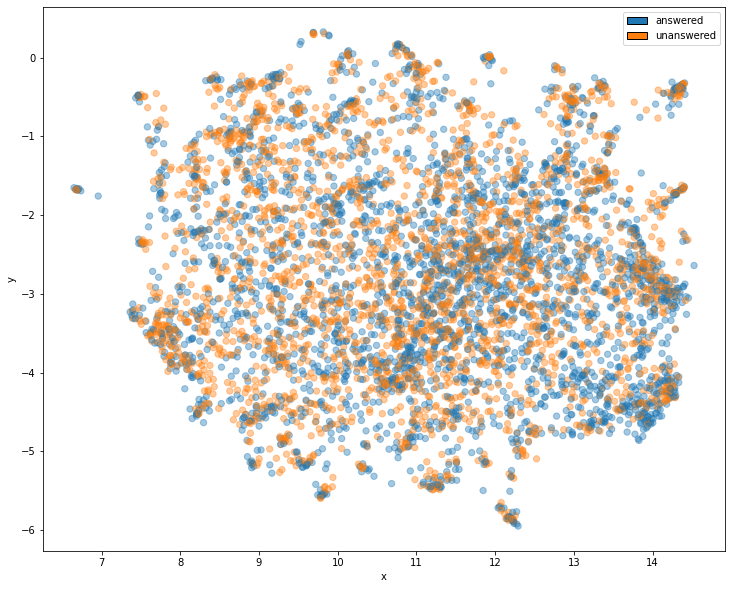

In [8]:
plot_embeddings(umap_bow, sent_labels)

This is a simplified representation of our data (the actual vectors are much larger than two dimensions), but can help discern trends, or with future labelling efforts. As you add features, it can be valuable to visualize embeddings to estimate whether classes look more separated.

## Pre-trained word embeddings
For this second approach, we load existing word vectors that were trained on a much larger corpus, which allows us to leverage general information from outside of our corpus. We will do so using the `spacy` library.

In [9]:
# Load a large model, and disable pipeline unnecessary parts for our task
# This speeds up the vectorization process significantly
# See https://spacy.io/models/en#en_core_web_mdfor details 
nlp = spacy.load('en_core_web_md', disable=['parser', 'tagger', 'ner'])

In [10]:
# Get the vector for each of our questions
# By default, the vector returned is the average of all vectors in the sentence
spacy_emb = train_author[train_author['is_question']]['body_text'].apply(lambda x: nlp(x).vector)
embeddings = np.vstack(spacy_emb)

In [14]:
umap_embedder = umap.UMAP()
umap_emb = umap_embedder.fit_transform(embeddings)

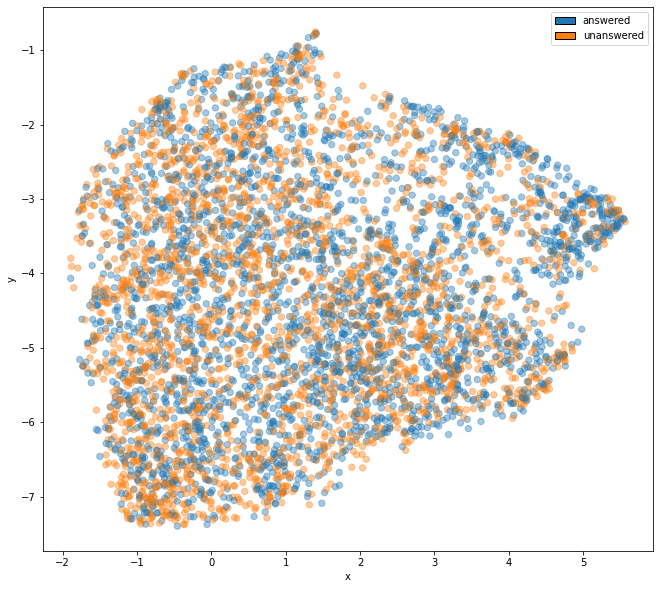

In [15]:
plot_embeddings(umap_emb, sent_labels)

The topology of our dataset looks different because our embedding method is different. The underlying data however, is the same.

Different embedding methods will cause a dataset to be represented differently. When using embeddings trained only on your data, documents that use the same vocabulary will be embedded close to each other. Using models trained on other corpuses however allows you to leverage information from these corpuses. With these models, semantically similar sentences may be embedded close to each other even if their vocabulary is completely different.

Changing the way you vectorize your data can often have a significant impact on model performance.